In [1]:
# Import all the necessary libraries

import numpy as np
import os
import random,shutil
import glob

from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread

from os import makedirs,listdir
from shutil import copyfile
from random import seed
from random import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D,Input
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Check tensorflow version

print(tf.__version__)

2.19.0


In [4]:
# Download the dataset

import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = 'o-vs-r-split-reduced-1200.zip'

print('Downloading File')
with requests.get(url,stream=True) as response:
  response.raise_for_status()
  with open(file_name,'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
      f.write(chunk)

def extract_file_with_progress(file_name):
  print('Extracting file with progress')
  with zipfile.ZipFile(file_name,'r') as zip_ref:
    members = zip_ref.infolist()
    with tqdm(total=len(members),unit='file') as progress_bar:
      for member in members:
        zip_ref.extract(member)
        progress_bar.update(1)
    print('Finished extracting file')

extract_file_with_progress(file_name)

print('Finished extracting file')
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [00:00<00:00, 5124.86file/s]

Finished extracting file
Finished extracting file


In [5]:
# Set model configurations

img_rows,img_cols = 150,150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows,img_cols,3)
labels = ['O','R']
seed = 42

In [6]:
# Create ImageDataGenerators for training, validation and testing

train_datagen = ImageDataGenerator(
    validation_split=val_split,
    rescale=1.0/255.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split=val_split,
    rescale=1.0/255.0
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [7]:
# Create training dataset

train_generator = train_datagen.flow_from_directory(
    directory=path,
    seed=seed,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    target_size=(img_rows,img_cols),
    subset='training'
)

Found 800 images belonging to 2 classes.


In [10]:
# Create validation dataset

val_generator = val_datagen.flow_from_directory(
    directory=path,
    seed=seed,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    target_size=(img_rows,img_cols),
    subset='validation'
)

Found 200 images belonging to 2 classes.


In [11]:
# Create testing dataset

test_generator = test_datagen.flow_from_directory(
    directory=path_test,
    seed=seed,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    target_size=(img_rows,img_cols)
)

Found 200 images belonging to 2 classes.


In [12]:
# Check how many batches in training dataset

print(len(train_generator))

25


Labels: [np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O')]


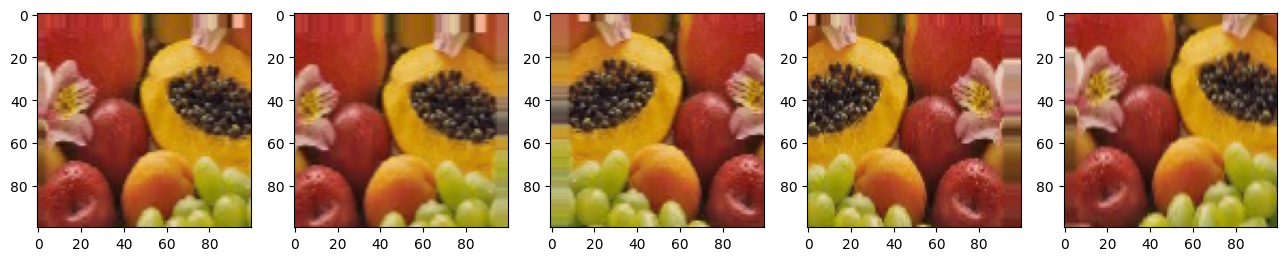

In [13]:
# Check how the ImageDataGenerator augments the image

from pathlib import Path

IMG_DIM = (100,100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img,target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1],train_labels[img_id:img_id+1],batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig,ax = plt.subplots(1,5,figsize=(16,6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]

In [14]:
# Loads the pre-trained VGG16 model without the top layers

from tensorflow.keras.applications import vgg16

vgg = vgg16.VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=input_shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [15]:
# Use the VGG16's feature extractions as the output of the base model

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input,output)

In [16]:
# Freeze the base model's layers

for layer in basemodel.layers:
  layer.trainable = False

In [17]:
# Build a classifier on top of the base model

model = Sequential()
model.add(basemodel)
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

In [18]:
# Check the summary of the model

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [19]:
# Compile the model with loss function and optimizer

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

In [21]:
# Create custom callbacks for the model

from tensorflow.keras.callbacks import LearningRateScheduler

checkpoint_path='O_R_tlearn_vgg16.keras'

# Tracking Loss and Learning Rate

class LossHistory_(tf.keras.callbacks.Callback):
  def on_train_begin(self,logs={}):
    self.losses = []
    self.lr = []

  def on_epoch_end(self,epoch,logs={}):
    self.losses.append(logs.get('loss'))
    self.lr.append(exp_decay(epoch))
    print('lr:',exp_decay(len(self.losses)))

# Setting custom learning rate

def exp_decay(epoch):
  initial_lrate = 1e-4
  k = 0.1
  lrate = initial_lrate * np.exp(-k*epoch)
  return lrate

loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

# Setting Early Stopping to reduce overfitting

keras_callbacks = [
    EarlyStopping(monitor='val_loss',
                  patience=4,
                  mode='min',
                  min_delta=0.01),

    # Save the model with the lowest loss

    ModelCheckpoint(checkpoint_path,monitor='val_loss',save_best_only=True,mode='min')
]

callbacks_list_ = [loss_history_,lrate_] + keras_callbacks

In [22]:
# Train the feature extractor model

extract_feat_model = model.fit(train_generator,
                               steps_per_epoch=5,
                               epochs=10,
                               callbacks=callbacks_list_,
                               validation_data=val_generator,
                               validation_steps=val_generator.samples // batch_size,
                               verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5717 - loss: 0.7317lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 110s 25s/step - accuracy: 0.5743 - loss: 0.7273 - val_accuracy: 0.7812 - val_loss: 0.5376 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7156 - loss: 0.5766lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 126s 29s/step - accuracy: 0.7109 - loss: 0.5801 - val_accuracy: 0.6979 - val_loss: 0.5389 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7022 - loss: 0.5709lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 18s/step - accuracy: 0.7081 - loss: 0.5655 - val_accuracy: 0.7812 - val_loss: 0.4469 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7476 - loss: 0.5009lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 18s/step - accuracy: 0.7490 - loss: 0.5009 - val_accuracy: 0.8073 - val_loss: 0.4254 - learning_rate: 7.4082e-05
Epoch

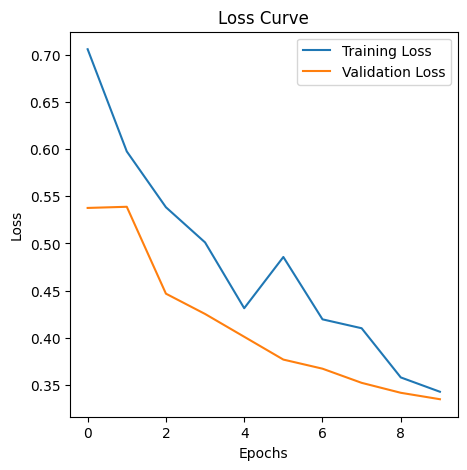

In [23]:
# Visualize the feature extraction model's training and validation loss

import matplotlib.pyplot as plt

history = extract_feat_model

plt.figure(figsize=(5,5))
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

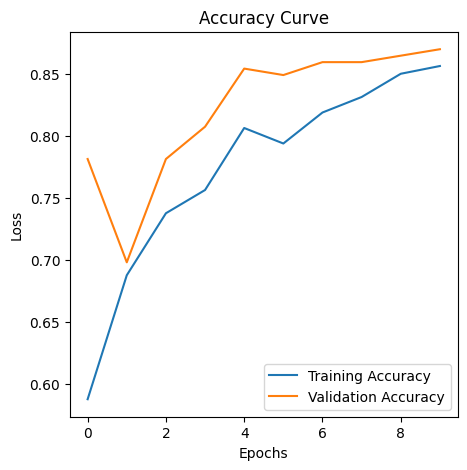

In [41]:
# Visualize the feature extraction model's training and validation accuracy

plt.figure(figsize=(5,5))
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# Load another VGG16 model

vgg1 = vgg16.VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=input_shape)

output = vgg1.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel1 = Model(vgg1.input,output)

for layer in basemodel1.layers:
  layer.trainable = False

set_trainable = False

# Check the layers of the VGG16 model

display([layer.name for layer in basemodel1.layers])

['input_layer_4',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_3']

In [30]:
# Unfreeze the final convolution layer so it can be fine-tuned

for layer in basemodel1.layers:
  if layer.name in ['block5_conv3']:
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

# Check the training states of all the layers

for layer in basemodel1.layers:
  print(f'{layer.name}: {layer.trainable}')

input_layer_4: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_3: True


In [35]:
# Create a new model for fine-tuning

model1 = Sequential()
model1.add(basemodel1)
model1.add(Dense(512,activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(512,activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))

# A new path to load the fine-tuned model

checkpoint_path1 = 'O_R_tlearn_fine_tune_vgg16.keras'

# Change the ModelCheckpoint path

keras_callbacks1 = [
    EarlyStopping(monitor='val_loss',
                  patience=4,
                  mode='min',
                  min_delta=0.01),
    ModelCheckpoint(checkpoint_path1,monitor='val_loss',save_best_only=True,mode='min')
]

callbacks_list_ = [loss_history_,lrate_] + keras_callbacks1

model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

# Train the new fine tuned model


fine_tune_model = model1.fit(train_generator,
                             steps_per_epoch=5,
                             epochs=10,
                             callbacks=callbacks_list_,
                             validation_data=val_generator,
                             validation_steps=val_generator.samples // batch_size,
                             verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4920 - loss: 0.8780lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 99s 22s/step - accuracy: 0.4975 - loss: 0.8657 - val_accuracy: 0.8385 - val_loss: 0.4580 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8199 - loss: 0.4724 lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 119s 27s/step - accuracy: 0.8166 - loss: 0.4724 - val_accuracy: 0.8594 - val_loss: 0.3709 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7958 - loss: 0.4217lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 135s 32s/step - accuracy: 0.7934 - loss: 0.4239 - val_accuracy: 0.8594 - val_loss: 0.3385 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8292 - loss: 0.3929lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 132s 31s/step - accuracy: 0.8316 - loss: 0.3880 - val_accuracy: 0.8021 - val_loss: 0.3998 - learning_rate: 7.4082e-05
Ep

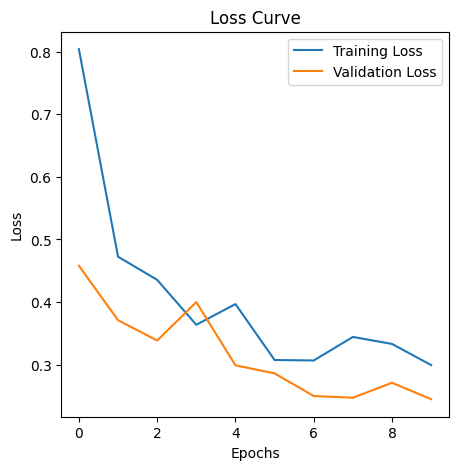

In [36]:
# Visualize the fine-tuned model's training and validation loss

history1 = fine_tune_model

plt.figure(figsize=(5,5))
plt.plot(history1.history['loss'],label='Training Loss')
plt.plot(history1.history['val_loss'],label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

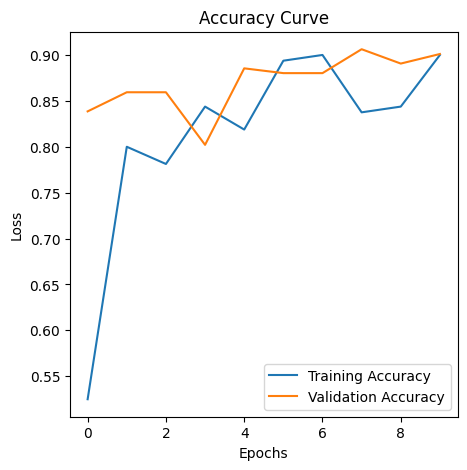

In [40]:
# Visualize the fine-tuned model's training and validation accuracy

plt.figure(figsize=(5,5))
plt.plot(history1.history['accuracy'],label='Training Accuracy')
plt.plot(history1.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
from pathlib import Path

# Load the feature extraction and fine-tuned models

extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

# Set the test file paths

test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

# Get the testing images

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img,target_size=(img_rows,img_cols))) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Rescale images

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

# Convert labels to numbers

class2num_lt = lambda l : [0 if x == 'O' else 1 for x in l]

# Convert numbers to labels

num2class_lt = lambda l : ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions on both models

predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled,verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled,verbose=0)

# Convert the predicted numbers to class labels

predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print the classificatin report for both models

print('Extract Features Model')
print(metrics.classification_report(test_labels,predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels,predictions_fine_tune_model))

Extract Features Model
              precision    recall  f1-score   support

           O       0.75      0.90      0.82        50
           R       0.88      0.70      0.78        50

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.78      0.94      0.85        50
           R       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



In [52]:
# Function to plot the image with true and predicted labels

def plot_image_with_title(image,model_name,actual_label,predicted_label):
  plt.imshow(image)
  plt.title(f'Model: {model_name}\n\n Actual: {actual_label}\n Predicted: {predicted_label}\n')
  plt.axis('off')
  plt.show()

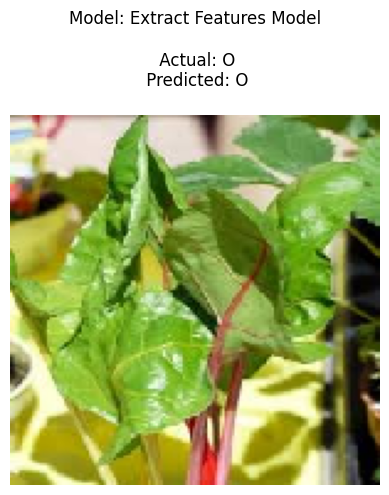

In [53]:
# Visualize the feature extraction model's prediction on an image

index_to_plot = 1

plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot]
)

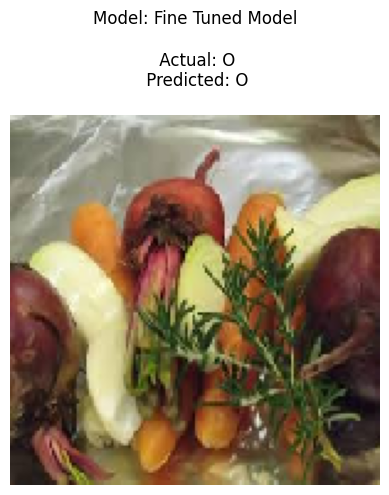

In [69]:
# Visualize the fine-tuned model's prediction on an image

index_to_plot = 2

plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine Tuned Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_fine_tune_model[index_to_plot]
)